Lifting line theory: Background and numerical example
====================================

In this notebook, we'll start to look at simulation-based design optimization. For the purposes of this section, we'll look at some simple aerodynamic optimization problems using lifting-line theory.

A good review of lifting line theory can be found here: 

https://en.wikipedia.org/wiki/Lifting-line_theory

In lifting line theory, the bound circulation can be written as a function of the span-wise coordinate $y$ as follows:

$\Gamma(\theta) = 2 b V_{\infty} \sum_{n=1}^{\infty} A_{n} sin(n\theta)$

here $y = \frac{b}{2} \cos(\theta)$. 

The Fourier coefficients $A_{n}$ are treated as the unknowns. In computations, the coefficients are truncated for $n = 1, \ldots, N$ so that we solve for $A_{1}, A_{2}, \ldots, A_{N}$.

The following system of $N$ equations can be obtained to find these coefficients:

$\begin{bmatrix} a_{11} & a_{12} & \ldots & a_{1N} \\ a_{21} & a_{22} & \ldots & a_{2N} \\ \vdots & \vdots & \ddots & \vdots \\ a_{N1} & a_{N2} & \ldots & a_{NN} \end{bmatrix} \begin{bmatrix} A_{1} \\ A_{2} \\ \vdots \\ A_{N} \end{bmatrix} = \begin{bmatrix} b_{1} \\ b_{2} \\ \vdots \\ b_{N} \end{bmatrix}$

where the entries $a_{nm}$ and $b_{n}$ are given by

$a_{mn} = \sin(n\theta_{m})\sin(\theta_{m}) + c_{l,\alpha} \frac{c(\theta_{m})}{4b} \sin(\theta_{m})$

$b_{m} = \frac{c(\theta_{m})}{4b} c_{l,\alpha} (\alpha_{\infty} + x_{m})$

Note that here $x_{m}$ is our design variable: The twist of the wing at the $m-th$ collocation point.

Output functions of interest:
---------------------------------

We're not interested in determining just the coefficients $A_{n}$, we want to know what the lift, drag, and perhaps root bending moment are on the wing as a function of the design variables.

The coefficient of lift produced by the wing is:

$C_{L} = \pi AR A_{1}$

The coefficient of drag produced by the wing is:

$C_{D} = \pi AR \sum_{n=1}^{N} n A_{n}^{2}$

The root bending moment coefficient defined is defined as

$C_{b} = \frac{M_{b}}{\frac{1}{2}\rho V_{\infty}^2 S b} = AR \sum_{n=1}^{N} c_{n} A_{n}$,

where $c_{n}$ are given as follows $c_{2} = 0$ and all other values are given by:

$c_{n} = \frac{(2\sin(n\pi/2) - \sin(\pi n))}{4 - n^2}$

Optimization problem formulations:
------------------------------------------

Now we want to solve an optimization problem. We want to design the wing so that it has minimum $C_{D}$ while meeting a requirement for lift $C_{L} = C_{L,\text{target}}$. This constrained optimization problem can be expressed as:

$\min_{x} \qquad C_{D} \qquad \text{such that} \qquad C_{L} = C_{L,\text{target}}$

This will give the classical lifting line result that the minimum induced drag is produced by an ellipitical lift distribution.

However, this results in a lift distribution which can overload the wing tip or a heavier structure. Therefore, we can consider an additional constraint where we seek to reduce the bending moment at the root of the wing by limiting $C_{b} \le C_{b,\text{target}}$.

$\min_{x} \qquad C_{D} \qquad \text{such that} \qquad  C_{L} = C_{L,\text{target}} \qquad \text{and} \qquad C_{b} \le C_{b,\text{target}}$

This will produce a more triangular lift distribution that shifts lift inboard.

Computational cost
-----------------------

These problems are solved with scipy.minimize. Note that as $N$ increases, the computational cost grows rapidly. That's because the lifting line theory code is invoked $N+1$ times for a gradient calculation for the objective and each constraint. This computational cost adds up quickly as the number of design variables increase. In addition, a larger design problem takes longer to solve, making these larger design problems even more computationally expensive.

To address this issue, we need a fast way to compute the gradient!

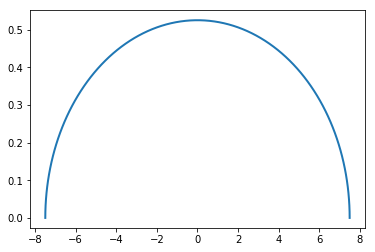

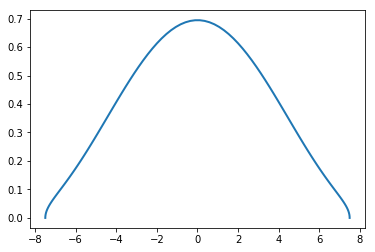

In [39]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pylab as plt
%matplotlib inline

class LiftingLine:
    def __init__(self, N, b, c_root, c_tip,
                 cl_alpha=2*np.pi, CL_target=1.0, Cb_target=1.0):
        """
        Instantiate the lifting line theory class.
        
        This creates the data needed to perform the lifting line theory
        analysis for a simple, tapered, unswept wing with a fixed lift
        and optionally specified wing root bending moment.
        
        Args:
            N (int): The number of Fourier coefficients
            b (float): The wing span
            c_root (float): The root chord
            c_tip (float): The tip chord
            cl_alpha (float): The lift curve slope of the airfoil
            CL_target (float): The target coefficient of lift
            Cb_target (float): The target bending moment coefficient
        """
        
        self.N = N
        
        self.alpha = 0.0
        self.b = b
        self.S = 0.5*self.b*(c_root + c_tip)
        self.cl_alpha = cl_alpha
        self.CL_target = CL_target
        self.Cb_target = Cb_target
        
        # Set the theta locations and compute their corresponding y-locations
        delta = 0.5*np.pi/self.N
        self.theta = np.linspace(delta, np.pi - delta, self.N)
        self.y = 0.5*self.b*np.cos(self.theta)

        u = np.absolute(2*self.y/self.b)
        self.chord = (1.0 - u)*c_root + u*c_tip 
        
        return    

    def solve_lifting_line_model(self, x):
        """
        Solve for the lifting line coefficients based on the values of
        the design variable twists.
        
        This code assembles and solves the governing equations for the
        lifting line theory. The resulting coefficients can be used
        to compute the lift, drag and bending moment coefficients.
        
        Args:
            x (np.array): An array of the twists of dimension self.N
        
        Returns:
            coef (np.array): An array of the Fourier coefficients
        """
        A = np.zeros((N, N))
        b = np.zeros(N)
        
        for m in range(self.N):
            for n in range(self.N):
                cval = 0.25*(self.chord[m]/self.b)*self.cl_alpha
                A[m,n] = np.sin((n+1)*self.theta[m])*np.sin(self.theta[m]) + cval*np.sin((n+1)*self.theta[m])

            b[m] = 0.25*self.chord[m]*np.sin(self.theta[m])*self.cl_alpha*(self.alpha + x[m])
            
        return np.linalg.solve(A, b)

    def compute_drag(self, x):
        """
        Compute the drag coefficient based on the design variable values.
        
        Args:
            x (np.array): An array of the twists of dimension self.N
            
        Returns:
            CD (float): The drag coefficient of the wing at the design point
        """
        AR = self.b**2/self.S
        coef = self.solve_lifting_line_model(x)
    
        s = 0.0
        for n in range(self.N):
            s += (n+1)*coef[n]**2
        return np.pi*AR*s

    def compute_lift_constraint(self, x):
        """
        Compute the lift constraint based on the design variable values.
        
        The lift constraint enforces that the lift must be equal to the
        target lift coefficient
        
        CL = CL_target
        
        Args:
            x (np.array): An array of the twists of dimension self.N
            
        Returns:
            con (float): The value of the lift constraint
        """
        AR = self.b**2/self.S
        coef = self.solve_lifting_line_model(x)
        return np.pi*AR*coef[0] - self.CL_target

    def compute_moment_constraint(self, x):
        """
        Compute the wing root bending moment constraint based on the
        design variable values.
        
        This constraint enforces that the bending moment must be less
        than the target bending moment coefficient:
        
        Cb_target - Cb >= 0.0
        
        Args:
            x (np.array): An array of the twists of dimension self.N
            
        Returns:
            con (float): The bending moment constraint value
        """
        AR = self.b**2/self.S
        coef = self.solve_lifting_line_model(x)
        
        s = 0.0
        for n in range(self.N):
            if n == 1:
                cval = 0.0
            else:
                cval = (2*np.sin(0.5*np.pi*(n+1)) - np.sin(np.pi*(n+1)))/(4.0 - (n+1)**2)
            s += cval*coef[n]
            
        return self.Cb_target - AR*s # >= 0.0
    
    def plot_gamma_dist(self, x):
        """
        Plot the circulation distribution as a function of the span.
        
        Args:
            x (np.array): An array of the twists of dimension self.N
        """
        coef = self.solve_lifting_line_model(x)
        
        size = 100
        theta = np.linspace(0, np.pi, size)
        y = 0.5*self.b*np.cos(theta)
        Gamma = np.zeros(size)
        
        for n in range(self.N):
            Gamma[:] += 2*self.b*coef[n]*np.sin((n+1)*theta)
            
        plt.figure()
        plt.plot(y, Gamma, linewidth=2)
        
        return

# Set the number of coefficients to use as well as the geometric
# properties of the wing.
N = 5
b = 15.0
c_root = 1.0
c_tip = 0.65

# Create the lifting line class.
lifting_line = LiftingLine(N, b, c_root, c_tip, Cb_target=0.175)

# Run the initial design problem: Minimize induced drag subject to a lift
# constraint.
x = np.ones(N)
res = minimize(lifting_line.compute_drag, x, method='SLSQP',
               constraints={'type': 'eq',
                            'fun': lifting_line.compute_lift_constraint})
lifting_line.plot_gamma_dist(res.x)

# Run the modified problem: Minimize induced drag subject to a lift
# constraint and a requirement that the root bending moment be bounded
# by the target bending moment coefficient.
x = np.ones(N)
res = minimize(lifting_line.compute_drag, x, method='SLSQP',
               constraints=[{'type': 'eq', 
                             'fun': lifting_line.compute_lift_constraint},
                            {'type': 'ineq',
                             'fun': lifting_line.compute_moment_constraint}])
lifting_line.plot_gamma_dist(res.x)

plt.show()
